### Time Series Analysis of Interbank Fx Rate of Ghana Cedi against US Dollar
                    using Decision Tree and Random Forest

#### Importing Libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree

### Loading and Understanding the data

In [2]:
fx = pd.read_csv('bankofghana_fxrates_2012-2022.csv')

In [3]:
fx.head()

,Date,Currency,Currency Pair,Buying,Selling,Mid Rate
0,31 Jan 2022,US Dollar,USDGHS,6.0206,6.0266,6.0236
1,28 Jan 2022,US Dollar,USDGHS,6.0196,6.0256,6.0226
2,27 Jan 2022,US Dollar,USDGHS,6.0196,6.0256,6.0226
3,26 Jan 2022,US Dollar,USDGHS,6.0094,6.0154,6.0124
4,25 Jan 2022,US Dollar,USDGHS,6.0079,6.0139,6.0109


In [4]:
fx.tail()

,Date,Currency,Currency Pair,Buying,Selling,Mid Rate
2493,09 Jan 2012,US Dollar,USDGHS,1.5700,1.6067,1.5884
2494,06 Jan 2012,US Dollar,USDGHS,1.5696,1.6063,1.5880
2495,05 Jan 2012,US Dollar,USDGHS,1.5675,1.6042,1.5859
2496,04 Jan 2012,US Dollar,USDGHS,1.5657,1.6024,1.5841
2497,03 Jan 2012,US Dollar,USDGHS,1.5657,1.6024,1.5841


**The data includes information about:**
* **Date** – Daily basis transactions are captured

* **Currency** – The column is for the individual foreign currencies

* **Currency Pair** - This is the combination of the Ghana Cedi and the US Dollar

* **Buying** – Buying rate at the end of each working day

* **Selling** – Selling rate at the biggining of each working day
* **Mid Rate** – Mid rate

Source of dataset: https://www.bog.gov.gh/treasury-and-the-markets/daily-interbank-fx-rates/


### Exploratory Data Analysis

In [5]:
print('Number of rows and columns:')
fx.shape

Number of rows and columns:


(2498, 6)

In [6]:
print('Data types:')
fx.dtypes

Data types:


Date              object
Currency          object
Currency Pair     object
Buying           float64
Selling           object
Mid Rate          object
dtype: object

In [7]:
print('Missing values:')
fx.isnull().sum()

Missing values:


Date             0
Currency         0
Currency Pair    0
Buying           0
Selling          0
Mid Rate         0
dtype: int64

In [8]:
fx.drop(columns=['Currency'], inplace=True)
fx.drop(columns=['Currency Pair'], inplace=True)

In [9]:
fx['Selling'] = pd.to_numeric(fx['Selling'], errors='coerce')
fx['Buying'] = pd.to_numeric(fx['Buying'], errors='coerce')
fx['Mid Rate'] = pd.to_numeric(fx['Mid Rate'], errors='coerce')

In [10]:
fx['Date'] = pd.to_datetime(fx['Date'])
fx['Year'] = fx['Date'].dt.year
fx['Month'] = fx['Date'].dt.month
fx['Week'] = fx['Date'].dt.week
fx['Day'] = fx['Date'].dt.day
fx['DayofWeek'] = fx['Date'].dt.dayofweek

In [11]:
rolling_mean_sel = fx['Selling'].rolling(window=30).mean()
rolling_mean_buy = fx['Buying'].rolling(window=30).mean()
rolling_mean_mid = fx['Mid Rate'].rolling(window=30).mean()
rolling_std_sel = fx['Selling'].rolling(window=30).std()
rolling_std_buy = fx['Buying'].rolling(window=30).std()
rolling_std_mid = fx['Mid Rate'].rolling(window=30).std()

In [12]:
fx.describe()

,Buying,Selling,Mid Rate,Year,Month,Week,Day,DayofWeek
count,2498.000000,2496.000000,2496.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000
mean,4.000041,4.009091,4.005405,2016.544836,6.464772,26.333066,15.884307,2.008807
std,1.360190,1.355370,1.357406,2.901499,3.459208,15.073082,8.690780,1.398810
min,0.000000,0.000000,0.000000,2012.000000,1.000000,1.000000,1.000000,0.000000
25%,3.021900,3.031825,3.030600,2014.000000,3.000000,13.000000,9.000000,1.000000
50%,4.204350,4.209300,4.207200,2017.000000,6.500000,26.000000,16.000000,2.000000
75%,5.255275,5.260600,5.258000,2019.000000,9.750000,39.750000,23.000000,3.000000
max,6.020600,6.026600,6.023600,2022.000000,12.000000,53.000000,31.000000,4.000000


### Data Visualisation 

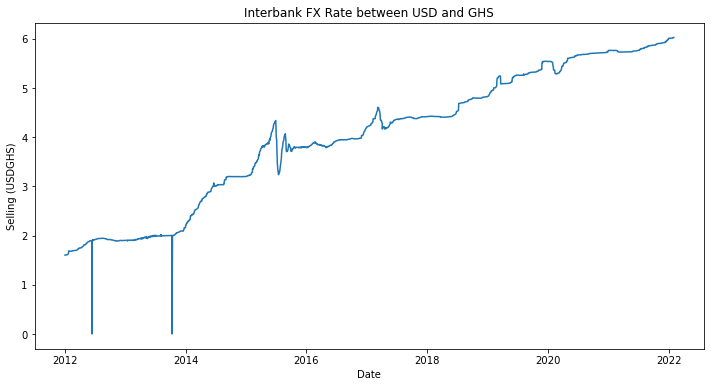

In [13]:
plt.figure(figsize=(12,6))
plt.plot(fx['Date'], fx['Selling'])
plt.title('Interbank FX Rate between USD and GHS')
plt.xlabel('Date')
plt.ylabel('Selling (USDGHS)')
plt.show()

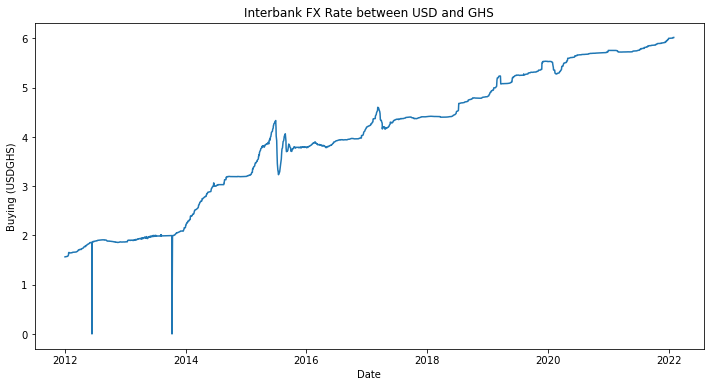

In [14]:
plt.figure(figsize=(12,6))
plt.plot(fx['Date'], fx['Buying'])
plt.title('Interbank FX Rate between USD and GHS')
plt.xlabel('Date')
plt.ylabel('Buying (USDGHS)')
plt.show()

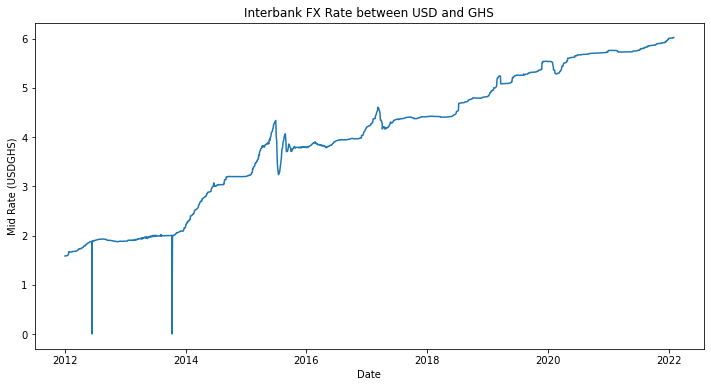

In [15]:
plt.figure(figsize=(12,6))
plt.plot(fx['Date'], fx['Mid Rate'])
plt.title('Interbank FX Rate between USD and GHS')
plt.xlabel('Date')
plt.ylabel('Mid Rate (USDGHS)')
plt.show()

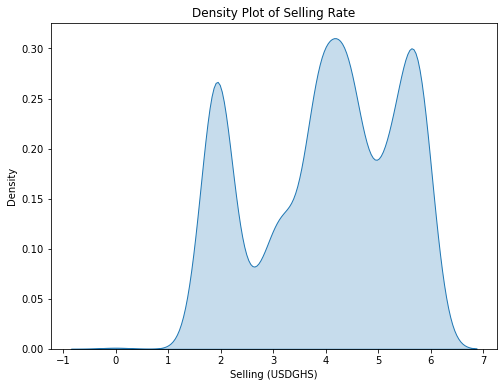

In [16]:
plt.figure(figsize=(8,6))
sns.kdeplot(fx['Selling'], shade=True)
plt.title('Density Plot of Selling Rate')
plt.xlabel('Selling (USDGHS)')
plt.show()

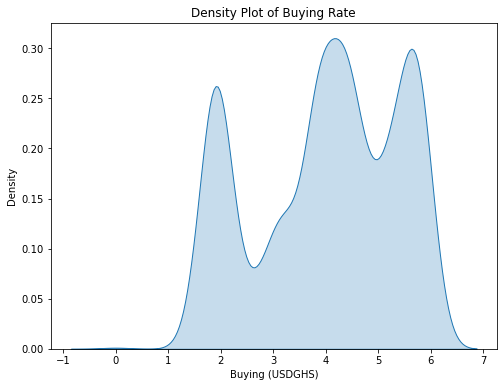

In [17]:
plt.figure(figsize=(8,6))
sns.kdeplot(fx['Buying'], shade=True)
plt.title('Density Plot of Buying Rate')
plt.xlabel('Buying (USDGHS)')
plt.show()

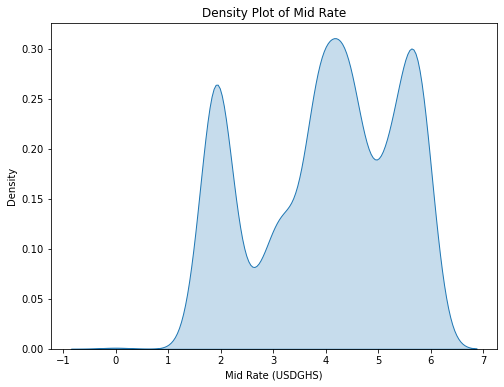

In [18]:
plt.figure(figsize=(8,6))
sns.kdeplot(fx['Mid Rate'], shade=True)
plt.title('Density Plot of Mid Rate')
plt.xlabel('Mid Rate (USDGHS)')
plt.show()

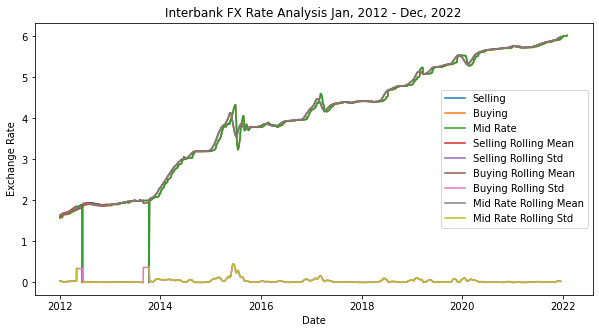

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(fx['Date'], fx['Selling'], label='Selling')
ax.plot(fx['Date'], fx['Buying'], label='Buying')
ax.plot(fx['Date'], fx['Mid Rate'], label='Mid Rate')
ax.plot(fx['Date'], rolling_mean_sel, label='Selling Rolling Mean')
ax.plot(fx['Date'], rolling_std_sel, label='Selling Rolling Std')
ax.plot(fx['Date'], rolling_mean_buy, label='Buying Rolling Mean')
ax.plot(fx['Date'], rolling_std_buy, label='Buying Rolling Std')
ax.plot(fx['Date'], rolling_mean_mid, label='Mid Rate Rolling Mean')
ax.plot(fx['Date'], rolling_std_mid, label='Mid Rate Rolling Std')
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Exchange Rate')
ax.set_title('Interbank FX Rate Analysis Jan, 2012 - Dec, 2022')
plt.show()

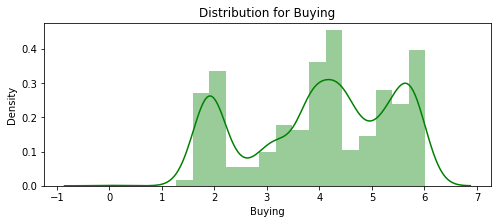

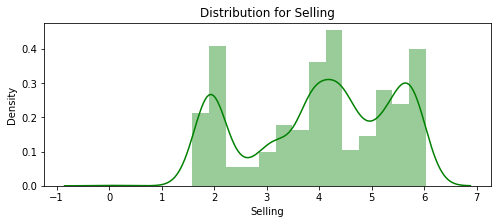

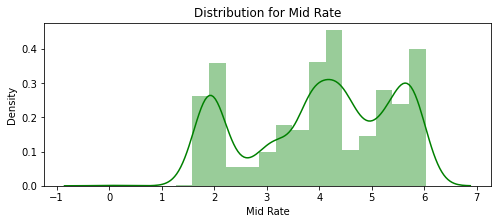

In [24]:
def distplot(feature, frame, color='g'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)
    
num_cols = ["Buying", 'Selling', 'Mid Rate']
for feat in num_cols: distplot(feat, fx)

### Feature Engineering 

In [25]:
fx.set_index('Date', inplace=True)

In [27]:
# Creating lag features for fx rate dataset

for i in range(1, 13):
    fx[f'lag_{i}'] = fx['Buying'].shift(i)
    fx[f'lag_{i}'] = fx['Selling'].shift(i)
    fx[f'lag_{i}'] = fx['Mid Rate'].shift(i)
    
fx.head()

,Buying,Selling,Mid Rate,Year,Month,Week,Day,DayofWeek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date,,,,,,,,,,,,,,,,,,,,
2022-01-31,6.0206,6.0266,6.0236,2022,1,5,31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-28,6.0196,6.0256,6.0226,2022,1,4,28,4,6.0236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-27,6.0196,6.0256,6.0226,2022,1,4,27,3,6.0226,6.0236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-26,6.0094,6.0154,6.0124,2022,1,4,26,2,6.0226,6.0226,6.0236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-25,6.0079,6.0139,6.0109,2022,1,4,25,1,6.0124,6.0226,6.0226,6.0236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
fx.isna().sum()

Buying        0
Selling       2
Mid Rate      2
Year          0
Month         0
Week          0
Day           0
DayofWeek     0
lag_1         3
lag_2         4
lag_3         5
lag_4         6
lag_5         7
lag_6         8
lag_7         9
lag_8        10
lag_9        11
lag_10       12
lag_11       13
lag_12       14
dtype: int64

In [29]:
def fill_nan_with_mean(fx, column_names):
    for col in column_names:
        column_names = fx[col].mean()
        fx[col] = fx[col].fillna(column_names)
    return fx

fx = fill_nan_with_mean(fx, ['Selling', 'Buying', 'Mid Rate', 'lag_1','lag_2','lag_3','lag_4','lag_5','lag_6','lag_7','lag_8','lag_9','lag_10','lag_11','lag_12'])
fx

,Buying,Selling,Mid Rate,Year,Month,Week,Day,DayofWeek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date,,,,,,,,,,,,,,,,,,,,
2022-01-31,6.0206,6.0266,6.0236,2022,1,5,31,0,4.006375,4.007346,4.008318,4.009289,4.010261,4.011233,4.012207,4.01318,4.014154,4.015129,4.016103,4.017078
2022-01-28,6.0196,6.0256,6.0226,2022,1,4,28,4,6.023600,4.007346,4.008318,4.009289,4.010261,4.011233,4.012207,4.01318,4.014154,4.015129,4.016103,4.017078
2022-01-27,6.0196,6.0256,6.0226,2022,1,4,27,3,6.022600,6.023600,4.008318,4.009289,4.010261,4.011233,4.012207,4.01318,4.014154,4.015129,4.016103,4.017078
2022-01-26,6.0094,6.0154,6.0124,2022,1,4,26,2,6.022600,6.022600,6.023600,4.009289,4.010261,4.011233,4.012207,4.01318,4.014154,4.015129,4.016103,4.017078
2022-01-25,6.0079,6.0139,6.0109,2022,1,4,25,1,6.012400,6.022600,6.022600,6.023600,4.010261,4.011233,4.012207,4.01318,4.014154,4.015129,4.016103,4.017078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-09,1.5700,1.6067,1.5884,2012,1,2,9,0,1.588400,1.588900,1.589300,1.591600,1.591600,1.593900,1.594800,1.59660,1.598400,1.613600,1.622200,1.667000
2012-01-06,1.5696,1.6063,1.5880,2012,1,1,6,4,1.588400,1.588400,1.588900,1.589300,1.591600,1.591600,1.593900,1.59480,1.596600,1.598400,1.613600,1.622200
2012-01-05,1.5675,1.6042,1.5859,2012,1,1,5,3,1.588000,1.588400,1.588400,1.588900,1.589300,1.591600,1.591600,1.59390,1.594800,1.596600,1.598400,1.613600


### Stationarity 

Checking for stationarity in the data using the Augmented Dickey-Fuller Test, Selling and Buying columns 


In [34]:
#Transfroming the dataset into stationarity series before testing with ADF to avoid non-stationarity

moving_average = fx.rolling(window=30).mean()
fx_series = fx - moving_average
fx_series.dropna(inplace=True)

In [35]:
def selling_stationarity(fx_series):
    """
    Performs the Augmented Dickey-Fuller Test to check for stationarity in the InterbankFX dataset.
    """
    result = adfuller(fx_series['Selling'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Lags Used: %d' % result[2])
    print('Number of Observations Used: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]['5%']:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")
print(selling_stationarity(fx_series))

ADF Statistic: -12.115989
p-value: 0.000000
Lags Used: 16
Number of Observations Used: 2452
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The time series is stationary
None


In [36]:
def buying_stationarity(fx_series):
    """
    Performs the Augmented Dickey-Fuller Test to check for stationarity in the InterbankFX dataset.
    """
    result = adfuller(fx_series['Buying'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Lags Used: %d' % result[2])
    print('Number of Observations Used: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]['5%']:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")
print(buying_stationarity(fx_series))

ADF Statistic: -11.892342
p-value: 0.000000
Lags Used: 14
Number of Observations Used: 2454
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The time series is stationary
None


In [38]:
#Standardization
ncolumn_names = fx.select_dtypes(include=['number']).columns

scaler = StandardScaler()
scaler.fit(fx.loc[:, ncolumn_names])
fx_scaled = fx.copy()
fx_scaled.loc[:, ncolumn_names] = scaler.transform(fx_scaled.loc[:, ncolumn_names])

In [39]:
train_size = int(0.8 * len(fx)) # 80% of the data for training
X = fx_scaled.iloc[:, :-1].values
y = fx_scaled.iloc[:, -1].values


#Split the train set into train and validation sets
train_size = int(len(X) * 0.8)  # 80% of the remaining data for training
train, valid = X[:-1], X[-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("fx:", fx_scaled.shape)
print("x_train:", X_train.shape)
print("x_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("Validation:", valid.shape)

fx: (2498, 20)
x_train: (1998, 19)
x_test: (500, 19)
y_train: (1998,)
y_test: (500,)
Validation: (1, 19)


In [40]:
len(X_train)

1998

In [42]:
len(X_test)

500

In [43]:
#Lasso regression, and GridSearch

param_grid = {'lasso__alpha': [0.1, 1, 10]}
pipe = make_pipeline(StandardScaler(), Lasso())
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print('The best hyperparameters and the associated R-squared score')
grid_search.best_score_

The best hyperparameters and the associated R-squared score


0.9845128586716829

In [ ]:
param_grid = {'lasso__alpha': [0.1, 1, 10]}

# Create the pipeline object with Lasso regression and standardization
pipe = make_pipeline(StandardScaler(), Lasso())

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best model and score
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print('The best hyperparameters and the associated R-squared score')
grid_search.best_score_

### Machine Learning Models

DecisionTreeRegressor and randomForestRegressor

#### Decision Tree model

In [44]:
model_dt = DecisionTreeRegressor(random_state=42, max_depth=100)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=100, random_state=42)

In [45]:
dt_y_pred = model_dt.predict(X_test)

# Print accuracy score
accuracy = model_dt.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Evaluating the model
mse_dt = mean_squared_error(y_test, dt_y_pred)
mae_dt = mean_absolute_error(y_test, dt_y_pred)
r2_dt = r2_score(y_test, dt_y_pred)

print(f'Mean Squared Error: {mse_dt:.2f}')
print(f'Mean Absolute Error: {mae_dt:.2f}')
print(f'R-Squared: {r2_dt:.2f}')

Accuracy: 0.99
Mean Squared Error: 0.01
Mean Absolute Error: 0.02
R-Squared: 0.99


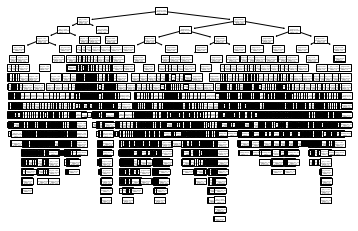

In [48]:
# Displaying the Decision Tree
trees = plot_tree(model_dt);

#### Random Forest model

In [49]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [50]:
rf_y_pred = model_rf.predict(X_test)

# Print accuracy score
accuracy = model_dt.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Evaluating the model
mse_rf = mean_squared_error(y_test, rf_y_pred)
mae_rf = mean_absolute_error(y_test, rf_y_pred)
r2_rf = r2_score(y_test, rf_y_pred)

print(f"Mean Sqaured Error: {mse_rf:.4f}")
print(f"Mean Sqaured Error: {mae_rf:.4f}")
print(f"R-Squared: {r2_rf:.4f}" )

Accuracy: 0.99
Mean Sqaured Error: 0.0537
Mean Sqaured Error: 0.1776
R-Squared: 0.9465


In [53]:
# Models Comparison 
print(f"DecisionTree - MSE: {mse_dt}, MAE: {mae_dt}, R2: {r2_dt}\n")

print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R2: {r2_rf}")

DecisionTree - MSE: 0.014058411809698836, MAE: 0.015792258531864074, R2: 0.9859744771577486

Random Forest - MSE: 0.053666830400736006, MAE: 0.17764992745583466, R2: 0.9464587205264914


                                                                *author: arbroni